In [ ]:
%pip install seaborn
%pip install scipy
%pip install statsmodels
%pip install pingouin

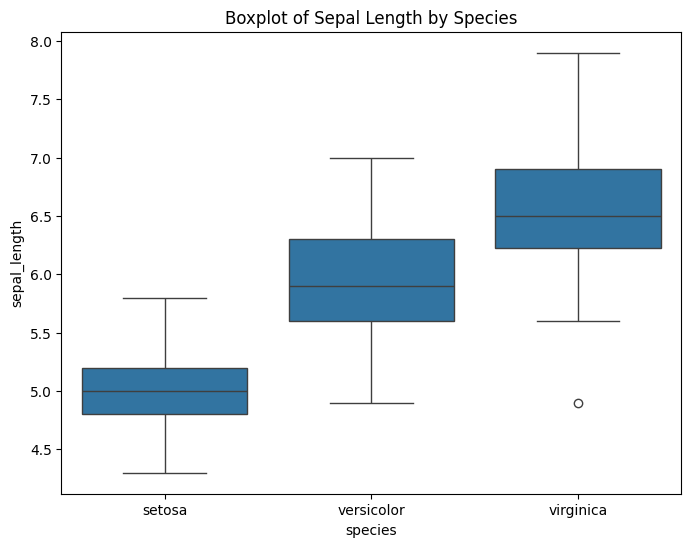

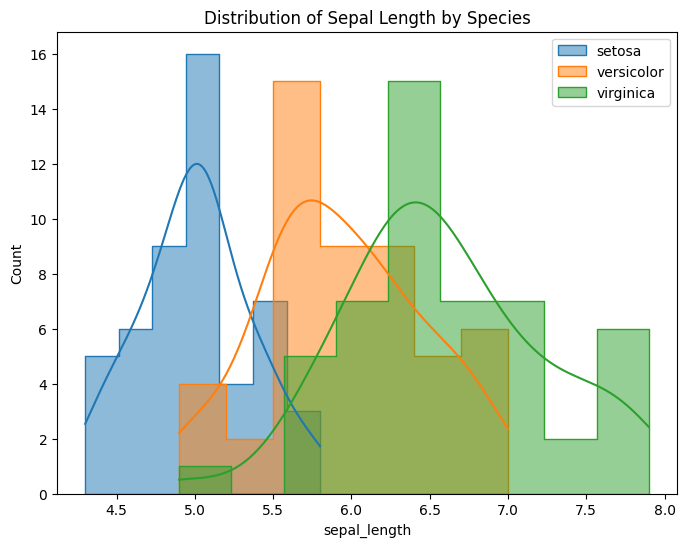

In [1]:
# --- Step 1: Load Data and Initial Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt

# Load the 'iris' dataset 
data = sns.load_dataset('iris')

# Select the relevant columns (one categorical, one numerical)
group_col = 'species'  # Categorical variable (grouping)
value_col = 'sepal_length'  # Numerical variable

# Create boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x=group_col, y=value_col, data=data)
plt.title('Boxplot of Sepal Length by Species')
plt.show()

# Create overlaid distribution plots (histograms and KDE)
plt.figure(figsize=(8, 6))
for species in data[group_col].unique():
    subset = data[data[group_col] == species]
    sns.histplot(subset[value_col], kde=True, label=species, element="step") 
plt.title('Distribution of Sepal Length by Species')
plt.legend()
plt.show()

In [2]:
# --- Step 2: Normality Tests ---
from scipy import stats

# 1. Get the unique group names (e.g., 'setosa', 'versicolor', 'virginica')
groups = data[group_col].unique()

# 2. Separate the numerical data ('value_col') into a list for each group - this will create a list of lists containing data for each group as a sublist within the main list
group_data = [data[data[group_col] == g][value_col] for g in groups]

# --- Shapiro-Wilk Test ---
print("--- Shapiro-Wilk Test ---")

for i, group_name in enumerate(groups):  # Loop through each group
    # Get the data for the current group
    current_group_data = group_data[i]

    # Perform the Shapiro-Wilk test
    statistic, p_value = stats.shapiro(current_group_data)

    # Print the results
    print(f"Group {group_name}: Statistic={statistic:.3f}, p-value={p_value:.3f}")

    # Explain the p-value
    if p_value > 0.05:
        print("\tSample looks Gaussian (fail to reject H0)")
    else:
        print("\tSample does not look Gaussian (reject H0)")

print("\n--- Kolmogorov-Smirnov Test ---")
for i, group_name in enumerate(groups):  # Loop through each group
    # Get the data for the current group.
    current_group_data = group_data[i]

    # Calculate the mean and standard deviation of the current group's data.
    mean = current_group_data.mean()
    std_dev = current_group_data.std()

    #Perform the Kolmogorov-Smirnov Test.  Compare the data to a NORMAL distribution.
    statistic, p_value = stats.kstest(current_group_data, 'norm', args=(mean, std_dev))

    print(f"Group: {group_name}, Statistic = {statistic:.3f}, p-value = {p_value:.4f}")
      # Explain the p-value
    if p_value > 0.05:
        print("\tSample looks Gaussian (fail to reject H0)")
    else:
        print("\tSample does not look Gaussian (reject H0)")

--- Shapiro-Wilk Test ---
Group setosa: Statistic=0.978, p-value=0.460
	Sample looks Gaussian (fail to reject H0)
Group versicolor: Statistic=0.978, p-value=0.465
	Sample looks Gaussian (fail to reject H0)
Group virginica: Statistic=0.971, p-value=0.258
	Sample looks Gaussian (fail to reject H0)

--- Kolmogorov-Smirnov Test ---
Group: setosa, Statistic = 0.115, p-value = 0.4889
	Sample looks Gaussian (fail to reject H0)
Group: versicolor, Statistic = 0.096, p-value = 0.7071
	Sample looks Gaussian (fail to reject H0)
Group: virginica, Statistic = 0.115, p-value = 0.4870
	Sample looks Gaussian (fail to reject H0)


## What to Do If Normality Tests Fail

**a) Do Nothing (with Caution):** If your sample sizes are *large* (often cited as n > ~30 in *each group*) and the deviations from normality are not *extreme* (check with histograms and Q-Q plots), you might proceed with ANOVA, but be cautious in your interpretation.  Mention the violation of normality in your report and acknowledge the potential limitations. This is the *least preferred* option, but sometimes justifiable with large samples.

**b) Data Transformations:**  Try to *transform* your data to make it more closely follow a normal distribution.  Common transformations include:

*   **Log Transformation:** `np.log(data)` – Useful for right-skewed data (long tail to the right).  Cannot be used with zero or negative values. You'll need to add a constant to the data before transformation: `np.log(data + 1)`.
*   **Square Root Transformation:** `np.sqrt(data)` – Also useful for right-skewed data, less strong than the log transformation. Cannot be used with negative values.
*   **Box-Cox Transformation:** `stats.boxcox(data)` – A more general power transformation that can handle various types of non-normality.  SciPy's `boxcox` function automatically finds the optimal transformation parameter (lambda).

*Important Note:* After transforming your data, you *must* re-check for normality using the same tests (Shapiro-Wilk, etc.).  If the transformed data passes the normality tests, you can proceed with ANOVA on the *transformed* data.  However, remember to interpret your results in terms of the *transformed* variable, *not* the original variable.  For example, if you use a log transformation, you're comparing means of *log-transformed* values, not the original values.  Back-transforming results for interpretation can be tricky.

**c) Non-parametric Tests:** Use a *non-parametric* test instead of ANOVA. Non-parametric tests do not assume normality. The most common alternative to one-way ANOVA is the **Kruskal-Wallis test** (`stats.kruskal(*group_data)` in SciPy).  The Kruskal-Wallis test compares the *ranks* of the data, rather than the actual values, making it robust to non-normality.  If the Kruskal-Wallis test is significant, you can use post-hoc tests like Dunn's test (not directly in SciPy, but available in packages like `scikit-posthocs`) to determine which groups differ significantly.

**d) Robust ANOVA (Welch's ANOVA):** Welch's ANOVA is more robust to violations of *homogeneity of variances*, but it also offers *some* robustness to non-normality, *especially* when sample sizes are unequal.  While it's primarily designed for unequal variances, it's often a better choice than standard ANOVA if normality is questionable.




In [3]:
# --- Step 3: Test for Homogeneity of Variances (Levene's Test) ---

levene_test = stats.levene(*group_data)
print("\n--- Levene's Test ---")
print(f"Statistic={levene_test.statistic:.3f}, p-value={levene_test.pvalue:.3f}")
if levene_test.pvalue > 0.05:
  print("Variances are equal (fail to reject H0)")
else:
  print("Variances are not equal (reject H0)")


--- Levene's Test ---
Statistic=6.353, p-value=0.002
Variances are not equal (reject H0)



--- Performing Welch's ANOVA (unequal variances) ---
statistic = 138.90828526893796
pvalue = 1.5050589627451595e-28
df = (2.0, np.float64(92.21114532045739))
df_num = 2.0
df_denom = 92.21114532045739
nobs_t = 150.0
n_groups = 3
means = [5.006 5.936 6.588]
nobs = [50. 50. 50.]
vars_ = [0.12424898 0.26643265 0.40434286]
use_var = unequal
welch_correction = True
tuple = (np.float64(138.90828526893796), np.float64(1.5050589627451595e-28))

--- ANOVA Summary Statistics ---
SST (Total Sum of Squares):       102.168
SSB (Between-group Sum of Squares): 63.212
SSE (Within-group Sum of Squares):  38.956
MST (Mean Square Between):        31.606
MSE (Mean Square Within):         0.422
F-statistic:                      138.908
P-value:                          0.000
DF Between:                       2
DF Within:                        92.211


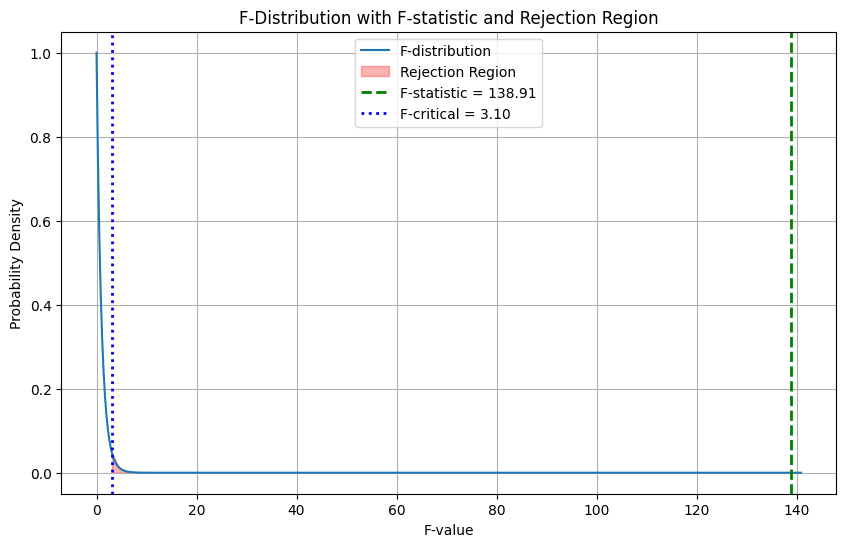

Result: Statistically significant difference between group means.


In [4]:
# --- Step 4: ANOVA or ANOVA with Welch's correction ---

import statsmodels.api as sm
from statsmodels.stats.oneway import anova_oneway
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Determine which ANOVA variant to use based on Levene's test
if levene_test.pvalue > 0.05:
    # --- Standard One-Way ANOVA (Equal variances assumed) ---
    print("\n--- Performing Standard ANOVA (equal variances) ---")
    anova_result = anova_oneway(group_data, use_var='equal')
    print(anova_result)

    f_statistic = anova_result.statistic
    p_value = anova_result.pvalue

    # Compute group stats
    grand_mean = data[value_col].mean()
    group_means = [g.mean() for g in group_data]
    group_sizes = [len(g) for g in group_data]
    k = len(group_data)
    N = len(data)

    # Between-group sum of squares (SSB) - SSB is more commonly used. We used SST in our PPT as it aligns better with terminology used in public health. 
    ssb = np.sum([group_sizes[i] * (group_means[i] - grand_mean) ** 2 for i in range(k)])
    
    # Within-group sum of squares (SSE) using sample variances
    sse = np.sum([(group_sizes[i] - 1) * np.var(group_data[i], ddof=1) for i in range(k)])
    
    sst = ssb + sse  # Total sum of squares - this is the more common usage of the term SST - sum of SSB and SSE.
    df_between = k - 1
    df_within = N - k
    mst = ssb / df_between
    mse = sse / df_within

else:
    # --- Welch's ANOVA (Unequal variances) ---
    print("\n--- Performing Welch's ANOVA (unequal variances) ---")
    anova_result = anova_oneway(group_data, use_var='unequal')
    print(anova_result)

    f_statistic = anova_result.statistic
    p_value = anova_result.pvalue

    # Compute group stats
    grand_mean = data[value_col].mean()
    group_means = [g.mean() for g in group_data]
    group_sizes = [len(g) for g in group_data]
    k = len(group_data)
    N = len(data)

    # Between-group and within-group sums of squares (same definitions - see notes above)
    ssb = np.sum([group_sizes[i] * (group_means[i] - grand_mean) ** 2 for i in range(k)]) 
    sse = np.sum([(group_sizes[i] - 1) * np.var(group_data[i], ddof=1) for i in range(k)])
    
    sst = ssb + sse
    df_between = k - 1
    df_within = anova_result.df_denom  # Welch's adjusted denominator df - note that this is different from df_within used above
    mst = ssb / df_between
    mse = sse / df_within  # Welch's adjusted denominator df

# --- Print ANOVA Summary ---
print("\n--- ANOVA Summary Statistics ---")
print(f"SST (Total Sum of Squares):       {sst:.3f}")
print(f"SSB (Between-group Sum of Squares): {ssb:.3f}")
print(f"SSE (Within-group Sum of Squares):  {sse:.3f}")
print(f"MST (Mean Square Between):        {mst:.3f}")
print(f"MSE (Mean Square Within):         {mse:.3f}")
print(f"F-statistic:                      {f_statistic:.3f}")
print(f"P-value:                          {p_value:.3f}")
print(f"DF Between:                       {df_between}")
print(f"DF Within:                        {df_within:.3f}")  # May be fractional for Welch

# --- Plot F-distribution with F-statistic and critical value ---

alpha = 0.05 # Change this value to adjust the significance level
f_critical = stats.f.ppf(1 - alpha, df_between, df_within)

# X-axis for the PDF plot
x = np.linspace(0, max(f_statistic, f_critical) + 2, 500)
f_dist = stats.f.pdf(x, df_between, df_within)

plt.figure(figsize=(10, 6))
plt.plot(x, f_dist, label='F-distribution')

# Shade rejection region
x_reject = np.linspace(f_critical, x[-1], 100)
plt.fill_between(x_reject, stats.f.pdf(x_reject, df_between, df_within),
                 color='red', alpha=0.3, label='Rejection Region')

# Plot F-statistic and F-critical value
plt.axvline(f_statistic, color='green', linestyle='--', linewidth=2, label=f'F-statistic = {f_statistic:.2f}')
plt.axvline(f_critical, color='blue', linestyle=':', linewidth=2, label=f'F-critical = {f_critical:.2f}')

# Labels and display
plt.xlabel('F-value')
plt.ylabel('Probability Density')
plt.title('F-Distribution with F-statistic and Rejection Region')
plt.legend()
plt.grid(True)
plt.show()

# --- Interpretation ---
if p_value < alpha:
    print("Result: Statistically significant difference between group means.")
else:
    print("Result: No statistically significant difference between group means.")


In [5]:
# --- Step 5: Run Posthoc tests ---

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pingouin as pg

if p_value < 0.05:
    if levene_test.pvalue > 0.05:
        print("\n--- Performing Tukey's HSD Post-Hoc Test ---")
        tukey_result = pairwise_tukeyhsd(data[value_col], data[group_col], alpha=0.05)
        print(tukey_result)
    else:
        print("\n--- Performing Games-Howell Post-Hoc Test ---")
        gh_result = pg.pairwise_gameshowell(dv=value_col, between=group_col, data=data)
        print(gh_result)
else:
    print("\n--- No Post-Hoc Test Needed (ANOVA/Welch's ANOVA was not significant) ---")



--- Performing Games-Howell Post-Hoc Test ---
            A           B  mean(A)  mean(B)   diff        se          T  \
0      setosa  versicolor    5.006    5.936 -0.930  0.088395 -10.520986   
1      setosa   virginica    5.006    6.588 -1.582  0.102819 -15.386196   
2  versicolor   virginica    5.936    6.588 -0.652  0.115825  -5.629165   

          df          pval    hedges  
0  86.538002  1.110223e-16 -2.088053  
1  76.515867  7.771561e-16 -3.053629  
2  94.025486  5.572540e-07 -1.117195  


### Conduct ANOVA for your own dataset

To run the test for your own data, complete the following steps: (1) create a data frame called *data* (2) specify the group_col and value_col (3) run steps 2,3,4,5. 

Don't forget to restart your kernel to refresh any previously defined variables. 

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ctiwari\AppData\Local\Temp\ipykernel_8912\1556624140.py:32: SyntaxWarning: invalid escape sequence '\s'
  raw_data = pd.read_csv(io.StringIO(data_str), sep='\s+')


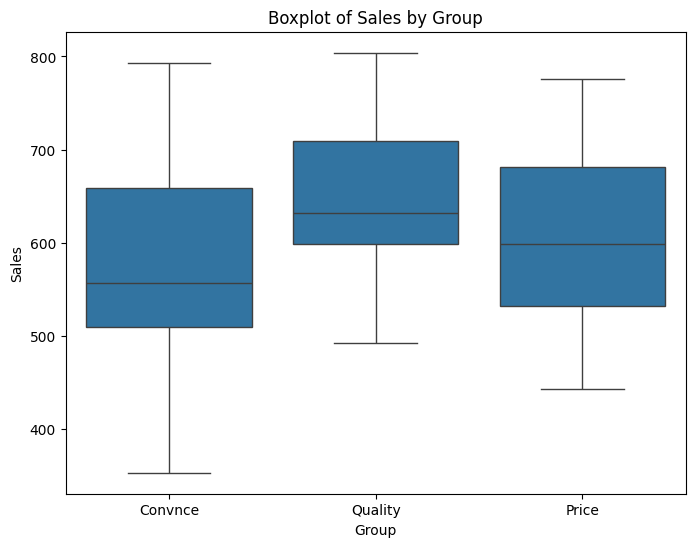

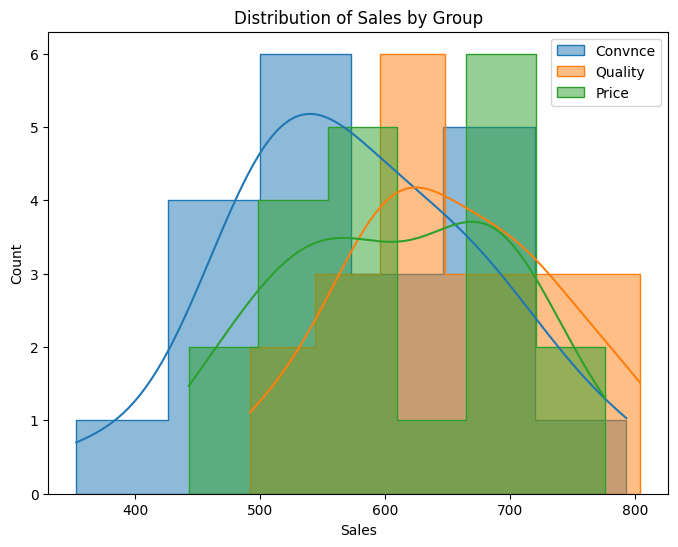

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io

# Data from the image
data_str = """
Convnce  Quality  Price
529      804      672
658      630      531
793      774      443
514      717      596
663      679      602
719      604      502
711      620      659
606      697      689
461      706      675
529      615      512
498      492      691
663      719      733
604      787      698
495      699      776
485      572      561
557      523      572
353      584      469
557      634      581
542      580      679
614      624      532
"""

# Load the data into a Pandas DataFrame
raw_data = pd.read_csv(io.StringIO(data_str), sep='\s+')

# Melt the DataFrame to long format for Seaborn plotting
data = pd.melt(raw_data, var_name='Group', value_name='Sales')

# --- Select the relevant columns (one categorical, one numerical) ---
# In this context, we've already transformed the data using pd.melt,
# where:
# - 'Group' column is the categorical variable (grouping).
# - 'Sales' column is the numerical variable.

group_col = 'Group'  # Categorical variable (grouping)
value_col = 'Sales'  # Numerical variable

# Create boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x=group_col, y=value_col, data=data)
plt.title(f'Boxplot of {value_col} by {group_col}')
plt.show()

# Create overlaid distribution plots (histograms and KDE)
plt.figure(figsize=(8, 6))
for group in data[group_col].unique():
    subset = data[data[group_col] == group]
    sns.histplot(subset[value_col], kde=True, label=group, element="step")
plt.title(f'Distribution of {value_col} by {group_col}')
plt.legend()
plt.show()